# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings
from transformers import AutoTokenizer
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.utils.average_meter import AverageMeter
from lib.data_tools.data import collate
from lib.model.inference import ensemble_inference
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=2,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          lgbm_a=2.998,
          lgbm_b=1.092,
          lgbm_n_folds=15,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-xsmall',
          n_folds=5,
          negative_sample=True,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          regression=False,
          scheduler='cosine',
          stride=192,
          tokenizer_ve

In [5]:
seed_everything()

In [6]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


### Setting Up WandB

In [7]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [8]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [10]:
class_weights = torch.tensor([1.0] * 6).to(device)

In [11]:
tokenizer = AutoTokenizer.from_pretrained(Paths.TOKENIZER_PATH)
vocabulary = tokenizer.get_vocab()
total_tokens = len(vocabulary)
print("Total number of tokens in the tokenizer:", total_tokens)
print(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of tokens in the tokenizer: 128003
DebertaV2TokenizerFast(name_or_path='output/microsoft/deberta-v3-xsmall/tokenizer_v2', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized

In [12]:
root_data_dir = "data/lgbm_deberta"

### 🛠️ Functions

In [13]:
def read_data_for_path(fold, part):
    fold_path = os.path.join(root_data_dir, f"fold_{fold}")
    part_path = os.path.join(fold_path, f"part_{part}")

    train_loader = torch.load(os.path.join(part_path, f"train_{fold}_{part}.pth"))
    valid_loader = torch.load(os.path.join(part_path, f"valid_{fold}_{part}.pth"))
    valid_csv = pd.read_csv(os.path.join(part_path, f"valid_{fold}_{part}.csv"), usecols=["score"])

    return train_loader, valid_loader, valid_csv.values

In [14]:
def get_input_and_labels(batch):
    inputs = collate(batch.pop("inputs"))
    labels = batch.pop("labels")

    for k, v in inputs.items():  # send each tensor value to `device`
        inputs[k] = v.to(device)

    labels = labels.to(device)  # send labels to `device`

    return inputs, labels

In [15]:
def grad_step(step, scaler, model, optimizer, scheduler, labels, losses, loss):
    if config.gradient_accumulation_steps > 1:
        loss = loss / config.gradient_accumulation_steps

    losses.update(loss.item(), labels.size(0))  # update loss function tracking
    scaler.scale(loss).backward()  # backward propagation pass
    grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)

    if (step + 1) % config.gradient_accumulation_steps == 0:
        scaler.step(optimizer)  # update optimizer parameters
        scaler.update()
        optimizer.zero_grad()  # zero out the gradients

        if config.batch_scheduler:
            scheduler.step()  # update learning rate

    return grad_norm

In [16]:
def log_metrics_training(
    fold,
    part,
    train_loader,
    epoch,
    scheduler,
    losses,
    n_steps_per_epoch,
    step,
    grad_norm,
):
    if step % config.print_freq == 0 or step == (len(train_loader) - 1):
        wandb.log(
            {
                f"train/epoch_f{fold}_p{part}": (step + 1 + (n_steps_per_epoch * epoch))
                / n_steps_per_epoch,
                f"train/train_loss_f{fold}_p{part}": losses.avg,
                f"train/grad_norm_f{fold}_p{part}": grad_norm,
                f"train/learning_rate_f{fold}_p{part}": scheduler.get_lr()[0],
            }
        )

In [17]:
def train_epoch(
    fold,
    part,
    train_loader,
    model,
    criterion,
    optimizer,
    epoch,
    scheduler,
):
    """One epoch training pass.

    Source:
    https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=26
    """
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    losses = AverageMeter()  # initiate AverageMeter to track the loss.
    n_steps_per_epoch = math.ceil(len(train_loader) / config.batch_size_train)

    with tqdm(
        train_loader,
        unit="train_batch",
        desc=f"Training Fold {fold} Part {part}",
    ) as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs, labels = get_input_and_labels(batch)

            with torch.cuda.amp.autocast(enabled=config.apex):
                y_preds = model(inputs)
                loss = criterion(y_preds, labels)

            grad_norm = grad_step(step, scaler, model, optimizer, scheduler, labels, losses, loss)

            log_metrics_training(
                fold,
                part,
                train_loader,
                epoch,
                scheduler,
                losses,
                n_steps_per_epoch,
                step,
                grad_norm,
            )

    return losses.avg

In [18]:
def valid_epoch(fold, part, epoch, valid_loader, model, criterion, valid_labels):
    model.eval()
    losses = AverageMeter()
    softmax = nn.Softmax(dim=1)
    prediction_dict = {}
    preds = []
    ids = []

    with tqdm(
        valid_loader,
        unit="valid_batch",
        desc=f"Validating Fold {fold} Part {part}",
    ) as tqdm_valid_loader:
        for _, batch in enumerate(tqdm_valid_loader):
            essay_ids = batch.pop("essay_ids")
            inputs, labels = get_input_and_labels(batch)

            with torch.no_grad():
                y_preds = model(inputs)
                loss = criterion(y_preds, labels)

            if config.gradient_accumulation_steps > 1:
                loss = loss / config.gradient_accumulation_steps

            losses.update(loss.item(), labels.size(0))
            preds.append(y_preds.to("cpu").numpy())
            ids.append(essay_ids)

    prediction_dict["predictions"] = softmax(torch.tensor(np.concatenate(preds)))
    prediction_dict["essay_id"] = np.concatenate(ids)

    _, predictions = torch.max(prediction_dict["predictions"], dim=1)

    score = get_score(valid_labels, predictions)

    wandb.log(
        {
            f"eval/eval_epoch_f{fold}_p{part}": epoch + 1,
            f"eval/eval_loss_f{fold}_p{part}": losses.avg,
            f"eval/qwk_score_f{fold}_p{part}": score,
        }
    )

    return losses.avg, score, prediction_dict

In [19]:
def get_model_save_path(fold, part):
    model_name = f"{config.model.replace('/', '_')}_fold_{fold}_part_{part}.pth"
    model_fold_path = os.path.join(Paths.MODEL_OUTPUT_PATH, f"fold_{fold}")

    if not os.path.exists(model_fold_path):
        os.makedirs(model_fold_path)

    model_save_path = os.path.join(model_fold_path, model_name)
    return model_save_path

In [20]:
def train_model_part(fold, part):
    train_loader, valid_loader, valid_labels = read_data_for_path(fold, part)
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    best_score = -np.inf

    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            part,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
        )

        # ======= EVALUATION ==========
        avg_val_loss, score, prediction_dict = valid_epoch(
            fold,
            part,
            epoch,
            valid_loader,
            model,
            criterion,
            valid_labels,
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - "
            + f"avg_train_loss: {avg_loss:.4f} "
            + f"avg_val_loss: {avg_val_loss:.4f} "
            + f"time: {elapsed:.0f}s "
            + f"Score: {score:.4f}"
        )

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save({"model": model.state_dict()}, get_model_save_path(fold, part))

    del model, optimizer, scheduler, criterion
    torch.cuda.empty_cache()
    gc.collect()

    return prediction_dict

In [21]:
def evaluate_group(fold, valid_fold, valid_labels, model_paths):
    predictions = ensemble_inference(
        valid_fold,
        tokenizer,
        model_paths,
        device,
        overall=False,
    )
    score = get_score(valid_labels, predictions)

    wandb.log(
        {
            f"eval/eval_epoch_f{fold}": config.epochs,
            f"eval/qwk_score_f{fold}": score,
        }
    )
    return predictions

In [22]:
def parse_prediction_dict(predictions):
    temp = {"essay_id": predictions["essay_id"]}

    for i in range(predictions["predictions"].shape[1]):
        temp[f"score_prob_{i}"] = predictions["predictions"][:, i]

    temp = pd.DataFrame(temp)
    return temp

In [23]:
def train_all_parts(fold):
    model_paths = {
        os.path.join(
            Paths.MODEL_OUTPUT_PATH,
            f"fold_{fold}/{config.model.replace('/', '_')}_fold_{fold}_part_{part}.pth",
        ): 1
        for part in range(config.n_folds)
    }

    train_oof_df = pd.DataFrame()
    for part in range(config.n_folds):
        prediction_dict = train_model_part(fold, part)
        predictions = parse_prediction_dict(prediction_dict)
        train_oof_df = pd.concat([train_oof_df, predictions])

    train_oof_df.to_csv(
        os.path.join(root_data_dir, f"fold_{fold}/oof_train_{fold}.csv"),
        index=False,
    )

    valid_fold = pd.read_csv(
        os.path.join(root_data_dir, f"fold_{fold}/valid_{fold}.csv")
    )
    valid_labels = valid_fold["score"].values
    valid_fold["pred_score"] = evaluate_group(
        fold,
        valid_fold,
        valid_labels,
        model_paths,
    )
    valid_fold.to_csv(
        os.path.join(root_data_dir, f"fold_{fold}/oof_valid_{fold}.csv"),
        index=False,
    )

    return valid_fold

In [24]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [25]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_all_parts(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv("data/lgbm_deberta/oof_df.csv", index=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.54valid_batch/s]


Epoch 1 - avg_train_loss: 1.2250 avg_val_loss: 0.9974 time: 163s Score: 0.7562
Epoch 1 - Save Best Score: 0.7562 Model


Validating Fold 0 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9755 avg_val_loss: 0.9807 time: 161s Score: 0.7455


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 1: 100%|██████████| 121/121 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2180 avg_val_loss: 1.0431 time: 161s Score: 0.7349
Epoch 1 - Save Best Score: 0.7349 Model


Validating Fold 0 Part 1: 100%|██████████| 121/121 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9571 avg_val_loss: 0.9927 time: 161s Score: 0.7545
Epoch 2 - Save Best Score: 0.7545 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2366 avg_val_loss: 1.0355 time: 161s Score: 0.7461
Epoch 1 - Save Best Score: 0.7461 Model


Validating Fold 0 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9590 avg_val_loss: 0.9316 time: 161s Score: 0.7918
Epoch 2 - Save Best Score: 0.7918 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2342 avg_val_loss: 1.0625 time: 161s Score: 0.7726
Epoch 1 - Save Best Score: 0.7726 Model


Validating Fold 0 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.60valid_batch/s]


Epoch 2 - avg_train_loss: 0.9584 avg_val_loss: 0.9497 time: 161s Score: 0.7793
Epoch 2 - Save Best Score: 0.7793 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2232 avg_val_loss: 1.1202 time: 161s Score: 0.6660
Epoch 1 - Save Best Score: 0.6660 Model


Validating Fold 0 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.9779 avg_val_loss: 1.0352 time: 161s Score: 0.7094
Epoch 2 - Save Best Score: 0.7094 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]


========== Fold: 0 result ==========
Score: 0.7583


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.1938 avg_val_loss: 1.0128 time: 161s Score: 0.7517
Epoch 1 - Save Best Score: 0.7517 Model


Validating Fold 1 Part 0: 100%|██████████| 119/119 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9552 avg_val_loss: 0.9401 time: 161s Score: 0.7751
Epoch 2 - Save Best Score: 0.7751 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2259 avg_val_loss: 1.0285 time: 161s Score: 0.7558
Epoch 1 - Save Best Score: 0.7558 Model


Validating Fold 1 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9633 avg_val_loss: 0.9754 time: 161s Score: 0.7609
Epoch 2 - Save Best Score: 0.7609 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2058 avg_val_loss: 1.0876 time: 161s Score: 0.6981
Epoch 1 - Save Best Score: 0.6981 Model


Validating Fold 1 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9585 avg_val_loss: 0.9795 time: 161s Score: 0.7572
Epoch 2 - Save Best Score: 0.7572 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 3: 100%|██████████| 118/118 [00:17<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2194 avg_val_loss: 1.0041 time: 161s Score: 0.7213
Epoch 1 - Save Best Score: 0.7213 Model


Validating Fold 1 Part 3: 100%|██████████| 118/118 [00:17<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9758 avg_val_loss: 0.9611 time: 161s Score: 0.7669
Epoch 2 - Save Best Score: 0.7669 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1 Part 4: 100%|██████████| 122/122 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2287 avg_val_loss: 1.0359 time: 161s Score: 0.7211
Epoch 1 - Save Best Score: 0.7211 Model


Validating Fold 1 Part 4: 100%|██████████| 122/122 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9800 avg_val_loss: 0.9618 time: 161s Score: 0.7415
Epoch 2 - Save Best Score: 0.7415 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.86test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.86test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.85test_batch/s]


========== Fold: 1 result ==========
Score: 0.7488


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.2106 avg_val_loss: 1.0334 time: 161s Score: 0.7058
Epoch 1 - Save Best Score: 0.7058 Model


Validating Fold 2 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9599 avg_val_loss: 0.9607 time: 161s Score: 0.7837
Epoch 2 - Save Best Score: 0.7837 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.55valid_batch/s]


Epoch 1 - avg_train_loss: 1.2182 avg_val_loss: 1.0181 time: 161s Score: 0.7595
Epoch 1 - Save Best Score: 0.7595 Model


Validating Fold 2 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9632 avg_val_loss: 0.9453 time: 161s Score: 0.7690
Epoch 2 - Save Best Score: 0.7690 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.54valid_batch/s]


Epoch 1 - avg_train_loss: 1.1997 avg_val_loss: 1.0198 time: 161s Score: 0.7220
Epoch 1 - Save Best Score: 0.7220 Model


Validating Fold 2 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.54valid_batch/s]


Epoch 2 - avg_train_loss: 0.9484 avg_val_loss: 0.9443 time: 161s Score: 0.7590
Epoch 2 - Save Best Score: 0.7590 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.59valid_batch/s]


Epoch 1 - avg_train_loss: 1.1915 avg_val_loss: 1.0507 time: 161s Score: 0.7570
Epoch 1 - Save Best Score: 0.7570 Model


Validating Fold 2 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.59valid_batch/s]


Epoch 2 - avg_train_loss: 0.9535 avg_val_loss: 0.9609 time: 161s Score: 0.7796
Epoch 2 - Save Best Score: 0.7796 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2295 avg_val_loss: 0.9875 time: 161s Score: 0.7868
Epoch 1 - Save Best Score: 0.7868 Model


Validating Fold 2 Part 4: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9545 avg_val_loss: 0.9182 time: 161s Score: 0.7979
Epoch 2 - Save Best Score: 0.7979 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.82test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.35test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.36test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:20<00:00,  5.39test_batch/s]


========== Fold: 2 result ==========
Score: 0.7704


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2112 avg_val_loss: 0.9962 time: 163s Score: 0.7363
Epoch 1 - Save Best Score: 0.7363 Model


Validating Fold 3 Part 0: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9357 avg_val_loss: 0.9594 time: 162s Score: 0.7719
Epoch 2 - Save Best Score: 0.7719 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.54valid_batch/s]


Epoch 1 - avg_train_loss: 1.2199 avg_val_loss: 1.0253 time: 162s Score: 0.7272
Epoch 1 - Save Best Score: 0.7272 Model


Validating Fold 3 Part 1: 100%|██████████| 120/120 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9755 avg_val_loss: 0.9658 time: 162s Score: 0.7768
Epoch 2 - Save Best Score: 0.7768 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.57valid_batch/s]


Epoch 1 - avg_train_loss: 1.1788 avg_val_loss: 0.9754 time: 162s Score: 0.7608
Epoch 1 - Save Best Score: 0.7608 Model


Validating Fold 3 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9775 avg_val_loss: 0.9393 time: 162s Score: 0.8011
Epoch 2 - Save Best Score: 0.8011 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.1889 avg_val_loss: 1.0522 time: 162s Score: 0.7583
Epoch 1 - Save Best Score: 0.7583 Model


Validating Fold 3 Part 3: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9549 avg_val_loss: 0.9429 time: 162s Score: 0.7839
Epoch 2 - Save Best Score: 0.7839 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.1777 avg_val_loss: 1.0272 time: 162s Score: 0.7661
Epoch 1 - Save Best Score: 0.7661 Model


Validating Fold 3 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.57valid_batch/s]


Epoch 2 - avg_train_loss: 0.9718 avg_val_loss: 0.9762 time: 162s Score: 0.7674
Epoch 2 - Save Best Score: 0.7674 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.84test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]


========== Fold: 3 result ==========
Score: 0.7823


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 0: 100%|██████████| 121/121 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2120 avg_val_loss: 1.0124 time: 161s Score: 0.7519
Epoch 1 - Save Best Score: 0.7519 Model


Validating Fold 4 Part 0: 100%|██████████| 121/121 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9635 avg_val_loss: 0.9703 time: 161s Score: 0.7710
Epoch 2 - Save Best Score: 0.7710 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 1 - avg_train_loss: 1.2177 avg_val_loss: 1.0098 time: 161s Score: 0.7612
Epoch 1 - Save Best Score: 0.7612 Model


Validating Fold 4 Part 1: 100%|██████████| 119/119 [00:18<00:00,  6.55valid_batch/s]


Epoch 2 - avg_train_loss: 0.9728 avg_val_loss: 0.9988 time: 161s Score: 0.7267


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 1 - avg_train_loss: 1.2169 avg_val_loss: 1.0719 time: 161s Score: 0.6830
Epoch 1 - Save Best Score: 0.6830 Model


Validating Fold 4 Part 2: 100%|██████████| 119/119 [00:18<00:00,  6.56valid_batch/s]


Epoch 2 - avg_train_loss: 0.9880 avg_val_loss: 0.9821 time: 161s Score: 0.7605
Epoch 2 - Save Best Score: 0.7605 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.2178 avg_val_loss: 1.0479 time: 161s Score: 0.7259
Epoch 1 - Save Best Score: 0.7259 Model


Validating Fold 4 Part 3: 100%|██████████| 119/119 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 0.9573 avg_val_loss: 0.9502 time: 161s Score: 0.7713
Epoch 2 - Save Best Score: 0.7713 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.58valid_batch/s]


Epoch 1 - avg_train_loss: 1.1933 avg_val_loss: 1.0545 time: 161s Score: 0.7281
Epoch 1 - Save Best Score: 0.7281 Model


Validating Fold 4 Part 4: 100%|██████████| 120/120 [00:18<00:00,  6.58valid_batch/s]


Epoch 2 - avg_train_loss: 1.0125 avg_val_loss: 0.9782 time: 161s Score: 0.7650
Epoch 2 - Save Best Score: 0.7650 Model


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 0 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.82test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 1 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 2 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 3 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Model 4 Inference: 100%|██████████| 109/109 [00:18<00:00,  5.83test_batch/s]


========== Fold: 4 result ==========
Score: 0.7599
========== CV ==========
Score: 0.7642


In [26]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [27]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

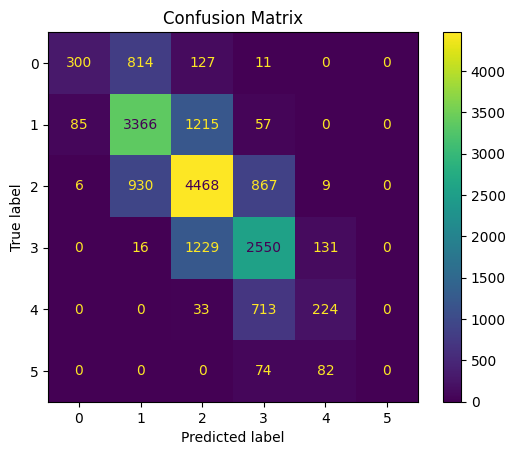

In [28]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [29]:
wandb.finish()

CV/qwk_score,▁
eval/eval_epoch_f0,▁
eval/eval_epoch_f0_p0,▁█
eval/eval_epoch_f0_p1,▁█
eval/eval_epoch_f0_p2,▁█
eval/eval_epoch_f0_p3,▁█
eval/eval_epoch_f0_p4,▁█
eval/eval_epoch_f1,▁
eval/eval_epoch_f1_p0,▁█
eval/eval_epoch_f1_p1,▁█
eval/eval_epoch_f1_p2,▁█
